# Loading Libraries

In [1]:
%%time
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np

from tqdm.notebook import tqdm
import gc

import warnings
warnings.filterwarnings('ignore')

from functools import partial
import scipy as sp

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns
import plotly.express as px

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, cohen_kappa_score, log_loss, accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE, RFECV
from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import CalibrationDisplay
from sklearn.inspection import PartialDependenceDisplay
from sklearn.linear_model import LogisticRegression
from collections import Counter
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC, LinearSVC

import lightgbm as lgb
from lightgbm import LGBMClassifier, early_stopping, log_evaluation

import xgboost as xgb
from xgboost import XGBClassifier

from catboost import CatBoostClassifier, Pool

CPU times: user 6.06 s, sys: 2.9 s, total: 8.96 s
Wall time: 11.7 s


# Reading Data Files

In [2]:
%%time
train = pd.read_csv('../input/playground-series-s5e7/train.csv', index_col=0)
test = pd.read_csv('../input/playground-series-s5e7/test.csv', index_col=0)

print('The dimension of the train dataset is:', train.shape)
print('The dimension of the test dataset is:', test.shape)

The dimension of the train dataset is: (18524, 8)
The dimension of the test dataset is: (6175, 7)
CPU times: user 17.9 ms, sys: 4.76 ms, total: 22.7 ms
Wall time: 54.5 ms


# Data Exploration

First, we start by exploring the target variable.

In [3]:
%%time
round(100*train["Personality"].value_counts(normalize=True), 2)

CPU times: user 1.89 ms, sys: 0 ns, total: 1.89 ms
Wall time: 2.97 ms


Personality
Extrovert    73.95
Introvert    26.05
Name: proportion, dtype: float64

From the above table, we can see the dataset is imbalanced. Next, we start running some simple sanity checks.

In [4]:
%%time
print('There are', sum(train.drop(columns=["Personality"]).duplicated()), 'duplicated observations in the train dataset')
print('There are', sum(test.duplicated()), 'duplicated observations in the test dataset')

There are 0 duplicated observations in the train dataset
There are 0 duplicated observations in the test dataset
CPU times: user 9.4 ms, sys: 2.15 ms, total: 11.6 ms
Wall time: 14.2 ms


There are no duplicates in either the `train` and `test` datasets. We next proceed to check to potential duplicated observations that may appear in the train and test datasets.


In [5]:
%%time
to_consider = train.drop(columns=["Personality"], axis=1).columns.tolist()

train_dup = train.drop(columns=["Personality"], axis=1).drop_duplicates()
test_dup = test.drop_duplicates()
duplicates = pd.merge(train_dup, test_dup, on=to_consider)

print('There are', duplicates.shape[0], 'rows that appear in the train and test dataset.\n')

There are 0 rows that appear in the train and test dataset.

CPU times: user 16.6 ms, sys: 1.83 ms, total: 18.5 ms
Wall time: 21.7 ms


Next, we check for missing values in the `train` and `test` datasets.

In [6]:
%%time
print("Missing values in the train dataset \n")
print(f"{train.isna().sum()}\n")

print("Missing values in the test dataset \n")
print(test.isna().sum())

Missing values in the train dataset 

Time_spent_Alone             1190
Stage_fear                   1893
Social_event_attendance      1180
Going_outside                1466
Drained_after_socializing    1149
Friends_circle_size          1054
Post_frequency               1264
Personality                     0
dtype: int64

Missing values in the test dataset 

Time_spent_Alone             425
Stage_fear                   598
Social_event_attendance      397
Going_outside                466
Drained_after_socializing    432
Friends_circle_size          350
Post_frequency               408
dtype: int64
CPU times: user 5.32 ms, sys: 119 µs, total: 5.44 ms
Wall time: 5.03 ms


From the above, we see that there are missing values in both datasets. Next. we create a few charts to explore potential patterns in the data.

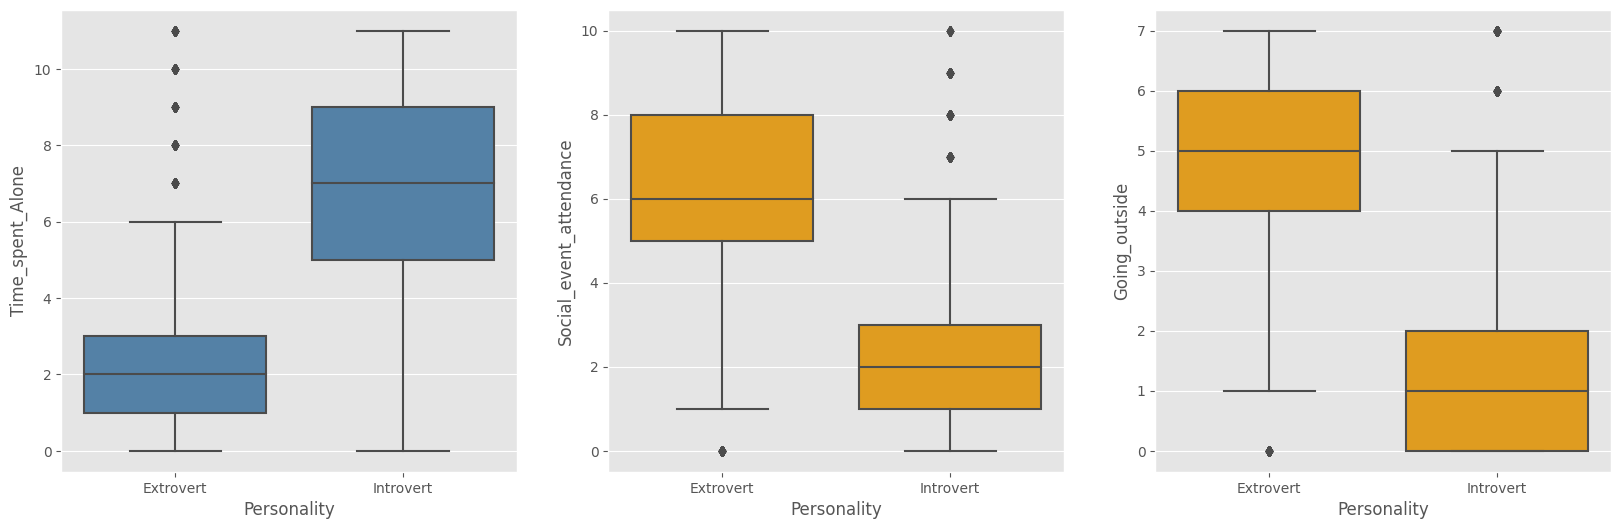

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

sns.boxplot(data=train, x="Personality", y="Time_spent_Alone", ax=ax[0], color="steelblue")
sns.boxplot(data=train, x="Personality", y="Social_event_attendance", ax=ax[1], color="orange");
sns.boxplot(data=train, x="Personality", y="Going_outside", ax=ax[2], color="orange");

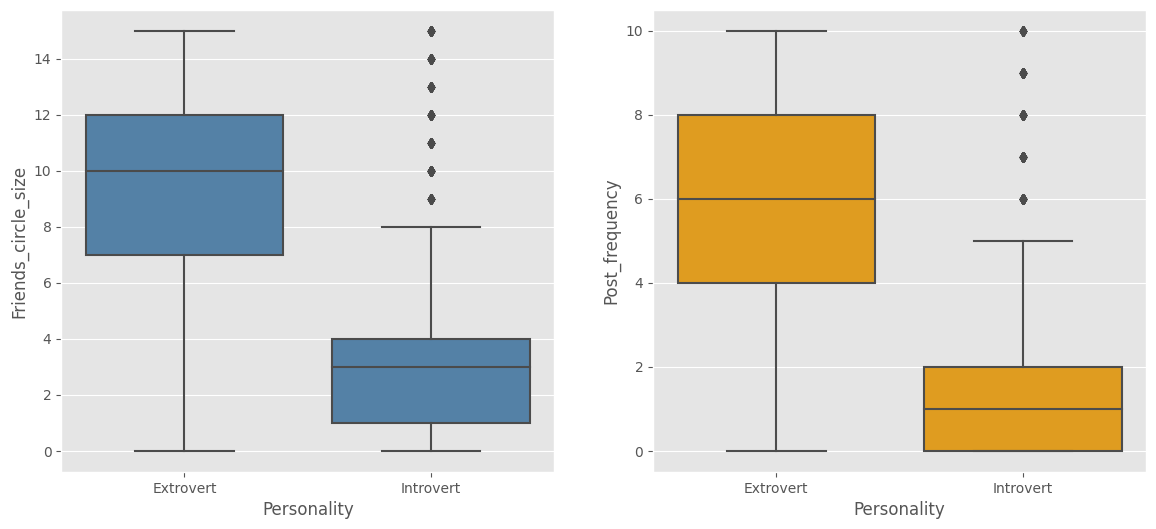

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

sns.boxplot(data=train, x="Personality", y="Friends_circle_size", ax=ax[0], color="steelblue")
sns.boxplot(data=train, x="Personality", y="Post_frequency", ax=ax[1], color="orange");

Based on the above boxplots, it seems that the classes are separable.

In [9]:
round(100*pd.crosstab(train["Stage_fear"], train["Personality"], normalize="columns"), 2)

Personality,Extrovert,Introvert
Stage_fear,,
No,98.12,7.23
Yes,1.88,92.77


In [10]:
round(100*pd.crosstab(train["Drained_after_socializing"], train["Personality"], normalize="columns"), 2)

Personality,Extrovert,Introvert
Drained_after_socializing,,
No,98.22,7.54
Yes,1.78,92.46


# Baseline Modeling 1.0

In this section, we train a couple of standard models using the raw data. First, we define the input and target features as follows.

In [11]:
%%time
X = train.drop(columns=["Personality"])
y = train["Personality"].map({"Extrovert": 0, "Introvert": 1})

del train
gc.collect()

cat_features = ["Stage_fear", "Drained_after_socializing"]
for col in cat_features:
    X[col] = X[col].fillna("missing").astype("category")
    test[col] = test[col].fillna("missing").astype("category")

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

CPU times: user 142 ms, sys: 1.85 ms, total: 144 ms
Wall time: 142 ms


Then, we train the `LGBMClassifier` model.

In [12]:
%%time
lgb_params = {'learning_rate': 0.0951305706297959,
 'max_depth': 7,
 'reg_alpha': 1.803743818590143,
 'reg_lambda': 0.01128965915670642,
 'num_leaves': 87,
 'colsample_bytree': 0.7749196423063947,
 'verbose': -1,
 'n_jobs': -1,
 'device': 'gpu'}

lgb_scores, lgb_oof_preds_df, lgb_test_preds_df = [], [], []
for i, (train_index, test_index) in enumerate(skf.split(X, y)):

    print(f"---- Working on Fold {i+1} ----")
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    dtrain = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_features)
    dtest = lgb.Dataset(X_test, label=y_test, reference=dtrain, categorical_feature=cat_features)

    md = lgb.train(params=lgb_params, 
                   train_set=dtrain,
                   num_boost_round=1000, 
                   valid_sets=[dtest], 
                   callbacks=[early_stopping(stopping_rounds=10, verbose=None)])

    md_pred = md.predict(X_test)
    md_pred = (md_pred > 0.5).astype(int)
            
    score = accuracy_score(y_test, md_pred)
    lgb_scores.append(score)
    print(f"Fold {i+1} accuracy: {score:.4f}")

    oof_preds = pd.DataFrame(
        md_pred,
        columns=["lgb_pred"]
    )
    oof_preds["y"] = y_test.values
    oof_preds["fold"] = i + 1
    oof_preds["index"] = X_test.index
    lgb_oof_preds_df.append(oof_preds)
    
    test_preds = pd.DataFrame(
        md.predict(test),
        columns=["lgb_pred"]
    )
    test_preds["fold"] = i + 1
    lgb_test_preds_df.append(test_preds)

lgb_mean = np.mean(lgb_scores)
lgb_sd = np.std(lgb_scores)
print(f"LightGBM CV accuracy: {lgb_mean:.4f} ± {lgb_sd:.4f}")

---- Working on Fold 1 ----


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


Fold 1 accuracy: 0.9671
---- Working on Fold 2 ----
Fold 2 accuracy: 0.9719
---- Working on Fold 3 ----
Fold 3 accuracy: 0.9725
---- Working on Fold 4 ----
Fold 4 accuracy: 0.9644
---- Working on Fold 5 ----
Fold 5 accuracy: 0.9654
---- Working on Fold 6 ----
Fold 6 accuracy: 0.9676
---- Working on Fold 7 ----
Fold 7 accuracy: 0.9708
---- Working on Fold 8 ----
Fold 8 accuracy: 0.9698
---- Working on Fold 9 ----
Fold 9 accuracy: 0.9703
---- Working on Fold 10 ----
Fold 10 accuracy: 0.9708
LightGBM CV accuracy: 0.9691 ± 0.0026
CPU times: user 12.8 s, sys: 1.24 s, total: 14 s
Wall time: 7.16 s


In [13]:
%%time
preds = []
for i in range(0, 10):
    preds.append(lgb_test_preds_df[i]["lgb_pred"])

submission = pd.read_csv("../input/playground-series-s5e7/sample_submission.csv", index_col=0)
submission["Personality"] = (np.mean(preds, axis=0) > 0.5).astype(int)
submission["Personality"] = submission["Personality"].map({0: "Extrovert", 1: "Introvert"})

del preds
gc.collect()

print(submission.head())
submission.to_csv("lgb_sub_1.csv")

      Personality
id               
18524   Extrovert
18525   Introvert
18526   Extrovert
18527   Extrovert
18528   Introvert
CPU times: user 152 ms, sys: 84 µs, total: 152 ms
Wall time: 157 ms


Next, we train the `XGBoost` model.

In [14]:
%%time
xgb_params = {'device': 'cuda',
 'max_depth': 6,
 'learning_rate': 0.015440059345672077,
 'gamma': 0.062065060162521446,
 'min_child_weight': 36,
 'colsample_bytree': 0.65,
 'reg_lambda': 5.612468414209365,
 'reg_alpha': 1.20950557811261,
 'n_jobs': -1}

test_xgb = xgb.DMatrix(test, enable_categorical=True)
xgb_scores, xgb_oof_preds_df, xgb_test_preds_df = [], [], []
for i, (train_index, test_index) in enumerate(skf.split(X, y)):

    print(f"---- Working on Fold {i+1} ----")
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
    dvalid = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)
             
    md = xgb.train(xgb_params,
                   dtrain=dtrain,
                   num_boost_round=1000,
                   evals=[(dvalid, 'validation')],
                   early_stopping_rounds=10,
                   verbose_eval=False)

    md_pred = md.predict(dvalid)
    md_pred = (md_pred > 0.5).astype(int)
            
    score = accuracy_score(y_test, md_pred)
    xgb_scores.append(score)
    print(f"Fold {i+1} accuracy: {score:.4f}")

    oof_preds = pd.DataFrame(
        md_pred,
        columns=["xgb_pred"]
    )
    oof_preds["y"] = y_test.values
    oof_preds["fold"] = i + 1
    oof_preds["index"] = X_test.index
    xgb_oof_preds_df.append(oof_preds)
    
    test_preds = pd.DataFrame(
        md.predict(test_xgb),
        columns=["xgb_pred"]
    )
    test_preds["fold"] = i + 1
    xgb_test_preds_df.append(test_preds)

xgb_mean = np.mean(xgb_scores)
xgb_sd = np.std(xgb_scores)
print(f"XGBoost CV accuracy: {xgb_mean:.4f} ± {xgb_sd:.4f}")

---- Working on Fold 1 ----
Fold 1 accuracy: 0.9676
---- Working on Fold 2 ----
Fold 2 accuracy: 0.9714
---- Working on Fold 3 ----
Fold 3 accuracy: 0.9692
---- Working on Fold 4 ----
Fold 4 accuracy: 0.9622
---- Working on Fold 5 ----
Fold 5 accuracy: 0.9633
---- Working on Fold 6 ----
Fold 6 accuracy: 0.9654
---- Working on Fold 7 ----
Fold 7 accuracy: 0.9703
---- Working on Fold 8 ----
Fold 8 accuracy: 0.9692
---- Working on Fold 9 ----
Fold 9 accuracy: 0.9698
---- Working on Fold 10 ----
Fold 10 accuracy: 0.9714
XGBoost CV accuracy: 0.9680 ± 0.0031
CPU times: user 7.84 s, sys: 197 ms, total: 8.04 s
Wall time: 6.89 s


In [15]:
%%time
preds = []
for i in range(0, 10):
    preds.append(xgb_test_preds_df[i]["xgb_pred"])

submission = pd.read_csv("../input/playground-series-s5e7/sample_submission.csv", index_col=0)
submission["Personality"] = (np.mean(preds, axis=0) > 0.5).astype(int)
submission["Personality"] = submission["Personality"].map({0: "Extrovert", 1: "Introvert"})

del preds
gc.collect()

print(submission.head())
submission.to_csv("xgb_sub_1.csv")

      Personality
id               
18524   Extrovert
18525   Introvert
18526   Extrovert
18527   Extrovert
18528   Introvert
CPU times: user 129 ms, sys: 1.74 ms, total: 131 ms
Wall time: 132 ms


Next, we train the `CatBoost` model.

In [16]:
%%time
cat_params = {'loss_function': 'Logloss',
 'iterations': 1000,
 'depth': 8,
 'task_type': 'GPU'}

# test_cat = Pool(data=test, cat_features=cat_features)
cat_scores, cat_oof_preds_df, cat_test_preds_df = [], [], []
for i, (train_index, test_index) in enumerate(skf.split(X, y)):

    print(f"---- Working on Fold {i+1} ----")
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
    eval_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)
             
    md = CatBoostClassifier(**cat_params).fit(model_pool, eval_set=eval_pool, verbose=0, 
                                              early_stopping_rounds=10)

    md_pred = md.predict_proba(X_test)[:, 1]
    md_pred = (md_pred > 0.5).astype(int)
            
    score = accuracy_score(y_test, md_pred)
    cat_scores.append(score)
    print(f"Fold {i+1} accuracy: {score:.4f}")

    oof_preds = pd.DataFrame(
        md_pred,
        columns=["cat_pred"]
    )
    oof_preds["y"] = y_test.values
    oof_preds["fold"] = i + 1
    oof_preds["index"] = X_test.index
    cat_oof_preds_df.append(oof_preds)
    
    test_preds = pd.DataFrame(
        md.predict_proba(test)[:, 1],
        columns=["cat_pred"]
    )
    test_preds["fold"] = i + 1
    cat_test_preds_df.append(test_preds)

cat_mean = np.mean(cat_scores)
cat_sd = np.std(cat_scores)
print(f"CatBoost CV accuracy: {cat_mean:.4f} ± {cat_sd:.4f}")

---- Working on Fold 1 ----
Fold 1 accuracy: 0.9682
---- Working on Fold 2 ----
Fold 2 accuracy: 0.9719
---- Working on Fold 3 ----
Fold 3 accuracy: 0.9719
---- Working on Fold 4 ----
Fold 4 accuracy: 0.9628
---- Working on Fold 5 ----
Fold 5 accuracy: 0.9654
---- Working on Fold 6 ----
Fold 6 accuracy: 0.9660
---- Working on Fold 7 ----
Fold 7 accuracy: 0.9708
---- Working on Fold 8 ----
Fold 8 accuracy: 0.9692
---- Working on Fold 9 ----
Fold 9 accuracy: 0.9703
---- Working on Fold 10 ----
Fold 10 accuracy: 0.9708
CatBoost CV accuracy: 0.9687 ± 0.0029
CPU times: user 1min 41s, sys: 8.25 s, total: 1min 49s
Wall time: 1min 38s


In [17]:
%%time
preds = []
for i in range(0, 10):
    preds.append(cat_test_preds_df[i]["cat_pred"])

submission = pd.read_csv("../input/playground-series-s5e7/sample_submission.csv", index_col=0)
submission["Personality"] = (np.mean(preds, axis=0) > 0.5).astype(int)
submission["Personality"] = submission["Personality"].map({0: "Extrovert", 1: "Introvert"})

del preds
gc.collect()

print(submission.head())
submission.to_csv("cat_sub_1.csv")

      Personality
id               
18524   Extrovert
18525   Introvert
18526   Extrovert
18527   Extrovert
18528   Introvert
CPU times: user 282 ms, sys: 657 µs, total: 282 ms
Wall time: 142 ms


Finally, we build a stacker as follows.

In [18]:
%%time
dat_1 = pd.concat(lgb_oof_preds_df).reset_index(drop=True)
dat_2 = pd.concat(xgb_oof_preds_df).reset_index(drop=True)
dat_3 = pd.concat(cat_oof_preds_df).reset_index(drop=True)

dat = pd.concat([dat_1["lgb_pred"], dat_2["xgb_pred"], dat_3["cat_pred"]], axis=1)
dat["y"] = dat_1["y"]

X = dat.drop(columns=["y"], axis=1)
y = dat["y"]

del dat_1, dat_2, dat_3, dat
gc.collect()

dat_1 = pd.concat(lgb_test_preds_df).reset_index(drop=True)
dat_2 = pd.concat(xgb_test_preds_df).reset_index(drop=True)
dat_3 = pd.concat(cat_test_preds_df).reset_index(drop=True)

dat = pd.concat([dat_1["lgb_pred"], dat_2["xgb_pred"], dat_3["cat_pred"]], axis=1)
dat["fold"] = dat_1["fold"]

del dat_1, dat_2, dat_3
gc.collect()

lr_md = LogisticRegression(max_iter=1000, random_state=42)
lr_cv = cross_val_score(lr_md, X, y, cv=10, scoring='accuracy', n_jobs=-1)
print(f"Logistic stacker CV accuracy: {lr_cv.mean():.5f} ± {lr_cv.std():.4f}")

svm_md = LinearSVC(random_state=42)
svm_cv = cross_val_score(svm_md, X, y, cv=10, scoring='accuracy', n_jobs=-1)
print(f"LinearSVC stacker CV accuracy: {svm_cv.mean():.5f} ± {svm_cv.std():.4f}")

lr_md.fit(X, y)
svm_md.fit(X, y)

lr_preds, svm_preds = [], []
for i in range(1, 11):
    temp_dat = dat[dat["fold"]==i].drop(columns=["fold"], axis=1).reset_index(drop=True)
    lr_preds.append(lr_md.predict_proba(temp_dat)[:, 1])
    svm_preds.append(svm_md.predict(temp_dat))

Logistic stacker CV accuracy: 0.96885 ± 0.0026
LinearSVC stacker CV accuracy: 0.96901 ± 0.0027
CPU times: user 1.74 s, sys: 23 ms, total: 1.76 s
Wall time: 2.75 s


In [19]:
%%time
submission = pd.read_csv("../input/playground-series-s5e7/sample_submission.csv", index_col=0)
submission["Personality"] = (np.mean(lr_preds, axis=0) > 0.5).astype(int)
submission["Personality"] = submission["Personality"].map({0: "Extrovert", 1: "Introvert"})
print(submission.head())
submission.to_csv("lr_stacker_sub_1.csv")

del submission
gc.collect()

submission = pd.read_csv("../input/playground-series-s5e7/sample_submission.csv", index_col=0)
submission["Personality"] = (np.mean(svm_preds, axis=0) > 0.5).astype(int)
submission["Personality"] = submission["Personality"].map({0: "Extrovert", 1: "Introvert"})
print(submission.head())
submission.to_csv("svm_stacker_sub_1.csv")

      Personality
id               
18524   Extrovert
18525   Introvert
18526   Extrovert
18527   Extrovert
18528   Introvert
      Personality
id               
18524   Extrovert
18525   Introvert
18526   Extrovert
18527   Extrovert
18528   Introvert
CPU times: user 166 ms, sys: 715 µs, total: 166 ms
Wall time: 167 ms


The following table summarizes the performance of the models considered so far.

In [20]:
%%time
df = pd.DataFrame()
df["Model"] = ["LGBM", "XGBoost", "CatBoost", "LR-stacker", "LinearSVC-stacker"]
df["Accuracy"] = [round(lgb_mean, 5), round(xgb_mean, 5), round(cat_mean, 5), round(lr_cv.mean(), 5), round(svm_cv.mean(), 5)]
print(df)

               Model  Accuracy
0               LGBM   0.96907
1            XGBoost   0.96799
2           CatBoost   0.96874
3         LR-stacker   0.96885
4  LinearSVC-stacker   0.96901
CPU times: user 4.51 ms, sys: 44 µs, total: 4.56 ms
Wall time: 4.17 ms
